In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os


import tensorflow as tf

import uproot

from AtlasCommonUtils import SetAtlasStyle

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

In [ ]:

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [ ]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [ ]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []

    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('e_px')
    scalar.append('e_py')
    #scalar.append('tau1b')
    cols.append('track_jt')
    cols.append('track_z')

    cols.append('track_jetpx')
    cols.append('track_jetpy')
    if(isMC):
        scalar.append('gen_x')
        scalar.append('gen_y')
        #scalar.append('gen_tau1b')
        scalar.append('gen_Q2')
        scalar.append('gene_px')
        scalar.append('gene_py')
        cols.append('gen_track_jt')
        cols.append('gen_track_z')
        cols.append('gen_track_jetpx')
        cols.append('gen_track_jetpy')
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print ('\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds')
    return pd.concat([x for x in dataframes])

In [11]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('track_jetpt = sqrt(track_jetpx*track_jetpx + track_jetpy*track_jetpy)', inplace=True)
    temp.eval('track_jetqt = sqrt( (e_px+track_jetpx)**2 + (e_py+track_jetpy)**2)',inplace=True)
    temp.eval('track_jetqtnorm = track_jetqt/sqrt(Q2)',inplace=True)
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
   # temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    temp = applyCut(temp, 'pass_reco==0 or track_jetpt >10.0', ' jet pt>10.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    #temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    #temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)
        temp.eval('gen_track_jetpt = sqrt(gen_track_jetpx*gen_track_jetpx + gen_track_jetpy*gen_track_jetpy)', inplace=True)
        temp.eval('gen_track_jetqt = sqrt( (gene_px+gen_track_jetpx)**2 + (gene_py+gen_track_jetpy)**2)',inplace=True)
        temp.eval('gen_track_jetqtnorm = gen_track_jetqt/sqrt(gen_Q2)',inplace=True)
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [12]:
path = '/home/marratia/data/'
dataname = path+'data.root'
mcname = path+'Django.root'
altmcname = path+'Rapgap.root'

In [48]:
datatree = uproot.open(dataname)['Data/minitree']


In [49]:
datatree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
x                    | float                    | AsDtype('>f4')
y                    | float                    | AsDtype('>f4')
Q2                   | float                    | AsDtype('>f4')
gen_x                | float                    | AsDtype('>f4')
gen_y                | float                    | AsDtype('>f4')
gen_Q2               | float                    | AsDtype('>f4')
tau1b                | float                    | AsDtype('>f4')
gen_tau1b            | float                    | AsDtype('>f4')
tauzQ                | float                    | AsDtype('>f4')
gen_tauzQ            | float                    | AsDtype('>f4')
vertex_z             | float                    | AsDtype('>f4')
ptmiss               | float                    | AsDtype('>f4')
ptratio              | float                    | AsDtype(

In [57]:
d = datatree.arrays(['track_z','track_jt','gen_track_z','gen_track_jt'],library="pd",flatten=True, entrystop=10)

TypeError: arrays() got an unexpected keyword argument 'flatten'

In [55]:
datatree.pandas.df(["track_z", "track_jt"], entrystop=10, flatten=False)

AttributeError: 'Model_TTree_v20' object has no attribute 'pandas'

In [54]:
d['track_z']

<Array [[0.192, 0.00578, 0.00497, ... []] type='262078 * var * float32'>

In [43]:
b = datafile['Data/minitree'].arrays(filter_name='/track|gen_track/',library="pd")

In [47]:
b.list()

AttributeError: 'tuple' object has no attribute 'list'

In [21]:
a = datafile['Data/minitree']['track_jt'].array(library="pd")

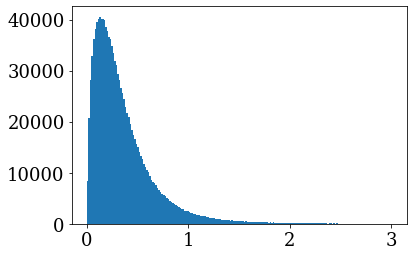

In [23]:
plt.hist(a,bins=200, range=(0.0,3.0))
plt.show()

In [ ]:
data     = getJetData([dataname])
#mc       = getJetData([mcname],isMC=True)
#altmc    = getJetData([altmcname],isMC=True)

## Get Nominal MC (Django in this case )

In [ ]:
mc = None
for filename in os.listdir(path):
    if 'Django_' in filename:
        print (filename)
        temp = getJetData([path+filename],isMC=True)
        #print (len(temp))
        mc = pd.concat([mc,temp])
        #print(len(mc))


## Get alternative MC

In [ ]:
altmc = None
for filename in os.listdir(path):
    if 'Rapgap_' in filename:
        print (filename)
        temp = getJetData([path+filename],isMC=True)
        altmc = pd.concat([altmc,temp])


In [ ]:
#mc       = getJetData([mcname],isMC=True)
altmc    = getJetData([altmcname],isMC=True)

In [ ]:
mc['pass_reco'] = np.where(mc['Q2']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_Q2']>0, 1, 0)
data['pass_reco'] = np.where(data['Q2']>0, 1, 0)

In [ ]:
mc['pass_reco'] = np.where(mc['track_jt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_track_jt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['track_jt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['gen_track_jt']>0, 1, 0)
data['pass_reco'] = np.where(data['track_jt']>0, 1, 0)

In [ ]:
mc.head()

In [ ]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc')
altmc = applyCutsJets(altmc, isMC=True)

In [ ]:
mc_cut = mc[:600000]
altmc_cut = altmc[:200000]

In [ ]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts

### Define UniFold Algorithm


In [ ]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## Define features using just MC and alt MC *this is CLOSURE TEST*

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']
Q2_unknown_G = altmc_cut['gen_logQ2']
Q2_unknown_S = altmc_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']
y_unknown_G = altmc_cut['gen_y']
y_unknown_S = altmc_cut['y']

#tau1b_0_G = mc_cut['gen_tau1b']
#tau1b_0_S =mc_cut['tau1b']
#tau1b_unknown_G = altmc_cut['gen_tau1b']
#tau1b_unknown_S = altmc_cut['tau1b']

jt_0_G = mc_cut['gen_track_jt']
jt_0_S = mc_cut['track_jt']
jt_unknown_G = altmc_cut['gen_track_jt']
jt_unknown_S = altmc_cut['track_jt']

z_0_G = mc_cut['gen_track_z']
z_0_S = mc_cut['track_z']
z_unknown_G = altmc_cut['gen_track_z']
z_unknown_S = altmc_cut['track_z']

jetpt_0_G = mc_cut['gen_track_jetpt']
jetpt_0_S = mc_cut['track_jetpt']
jetpt_unknown_G = altmc_cut['gen_track_jetpt']
jetpt_unknown_S = altmc_cut['track_jetpt']

jetqt_0_G = mc_cut['gen_track_jetqtnorm']
jetqt_0_S = mc_cut['track_jetqtnorm']
jetqt_unknown_G = altmc_cut['gen_track_jetqtnorm']
jetqt_unknown_S = altmc_cut['track_jetqtnorm']


#jetpt_0_G = mc_cut['genjet_pt']
#jetpt_0_S =mc_cut['jet_pt']
#jetpt_unknown_G = altmc_cut['genjet_pt']
#jetpt_unknown_S = altmc_cut['jet_pt']

In [ ]:
theta0_G=np.c_[(Q2_0_G, y_0_G, jt_0_G,z_0_G, jetpt_0_G, jetqt_0_G)]
theta0_S=np.c_[(Q2_0_S, y_0_S, jt_0_S,z_0_S, jetpt_0_S, jetqt_0_S)]
theta_unknown_S=np.c_[(Q2_unknown_S, y_unknown_S, jt_unknown_S, z_unknown_S,jetpt_unknown_S, jetqt_unknown_S)]
theta_unknown_G=np.c_[(Q2_unknown_G, y_unknown_G, jt_unknown_G, z_unknown_G, jetpt_unknown_G, jetqt_unknown_G)]

In [ ]:
theta0_G=np.c_[(Q2_0_G, y_0_G, jt_0_G)]
theta0_S=np.c_[(Q2_0_S, y_0_S, jt_0_S)]
theta_unknown_S=np.c_[(Q2_unknown_S, y_unknown_S, jt_unknown_S)]
theta_unknown_G=np.c_[(Q2_unknown_G, y_unknown_G, jt_unknown_G)]

In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

In [ ]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(0,2, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Define Multifold 

In [ ]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold two variables simultaneously

In [ ]:
K.clear_session()

In [ ]:
iterations = 1# use ~4 iterations
num_observables= 6

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)

## Plot CLOSURE TEST RESULTS

In [ ]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,100 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(y_0_G[y_0_G!=-10], bins=bins, label=r'Django (truth)', **plot_style_2)
    ax[0,0].hist(y_0_G[y_0_G!=-10],
               bins=bins,
               weights=weights[i, 1, :][y_0_G!=-10],
               label=r'Rapgap unfolded.',
               **plot_style_1)

    ax[0,0].hist(y_unknown_G,
               bins=bins,
               label=r'Rapgap (Truth)',
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 4,100 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(Q2_0_G[Q2_0_G!=-10], bins=bins, label=r'Django (truth)', **plot_style_2)
    ax[0,1].hist(Q2_0_G[Q2_0_G!=-10],
               bins=bins,
               weights=weights[i, 1, :][Q2_0_G!=-10],
               label=r'Rapgap unfolded.',
               **plot_style_1)

    ax[0,1].hist(Q2_unknown_G,
               bins=bins,
               label=r'Rapgap (Truth)',
               **plot_style_2)
    
    
    
    bins = np.linspace(0.01,1,100 )

    ax[0,2].set_xlabel(r'$z_{jet} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(z_0_G[z_0_G!=-10], bins=bins, label=r'Django (truth)', **plot_style_2)
    ax[0,2].hist(z_0_G[z_0_G!=-10],
               bins=bins,
               weights=weights[i, 1, :][z_0_G!=-10],
               label=r'Rapgap unfolded.',
               **plot_style_1)

    ax[0,2].hist(z_unknown_G,
               bins=bins,
               label=r'Rapgap (Truth)',
               **plot_style_2)
    ax[0,2].set_yscale('log')
    ax[0,2].set_xscale('log')

    
    bins = np.linspace(0,3,100 )

    ax[1,0].set_xlabel(r'$j_{T} $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jt_0_G[jt_0_G!=-10], bins=bins, label=r'Django (truth)', **plot_style_2)
    ax[1,0].hist(jt_0_G[jt_0_G!=-10],
               bins=bins,
               weights=weights[i, 1, :][jt_0_G!=-10],
               label=r'Rapgap unfolded.',
               **plot_style_1)

    ax[1,0].hist(jt_unknown_G,
               bins=bins,
               label=r'Rapgap (Truth)',
               **plot_style_2)
    ax[1,0].set_yscale('log')
    
    bins = np.linspace(0,60,100 )

    ax[1,1].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(jetpt_0_G[jetpt_0_G!=-10], bins=bins, label=r'Django (truth)', **plot_style_2)
    ax[1,1].hist(jetpt_0_G[jetpt_0_G!=-10],
               bins=bins,
               weights=weights[i, 1, :][jetpt_0_G!=-10],
               label=r'Rapgap unfolded.',
               **plot_style_1)

    ax[1,1].hist(jetpt_unknown_G,
               bins=bins,
               label=r'Rapgap (Truth)',
               **plot_style_2)
    
    
    bins = np.linspace(0,3,100 )

    ax[1,2].set_xlabel(r'$jet q_{T} $',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(jetqt_0_G[jetqt_0_G!=-10], bins=bins, label=r'Django (truth)', **plot_style_2)
    ax[1,2].hist(jetqt_0_G[jetqt_0_G!=-10],
               bins=bins,
               weights=weights[i, 1, :][jetqt_0_G!=-10],
               label=r'Rapgap unfolded.',
               **plot_style_1)

    ax[1,2].hist(jetqt_unknown_G,
               bins=bins,
               label=r'Rapgap (Truth)',
               **plot_style_2)
    
    
    
    
    

In [ ]:
plt.hist(mc['track_jetpt'],bins=100)

## Compute efficiency 

In [ ]:
bins = np.linspace(0,20,100)
plt.hist(mc['genjet_pt'],bins=bins,alpha=0.3)
plt.hist(mc.query('pass_reco==1')['genjet_pt'],bins=bins,alpha=0.3)

plt.show()

In [ ]:
#numerator
mask = np.logical_and(theta0_S[:,0]!=-10,theta0_G[:,0]!=-10)
print (mask) 
num,x,_  = plt.hist(jetpt_0_G[mask], weights=weights[-1, 1, :][mask],bins=20,label='numerator, weighted',alpha=0.3)
den,x,_ = plt.hist(jetpt_0_G[theta0_G[:,0]!=-10], weights=weights[-1, 1, :][theta0_G[:,0]!=-10],bins=20,label='numerator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

#plt.hist(theta0_G[theta0_S[:,0]!=-10][:,1])
plt.show()
eff_weighted= np.true_divide(num,den)
print(sum(num))
print(sum(den))
print(sum(num)/sum(den))
#plt.legend()

In [ ]:
bins = np.linspace(2, 5, 101)

for i in range(1):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(10, 5))
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    
    gs = plt.GridSpec(1, 2)
    gs.update(left=0.08, right=0.925,
              top=0.95, bottom=0.05,
              hspace=0.3, wspace=0.5)

    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])     
    
    ax1.hist(theta0_G[theta0_G[:,0]!=-10][:,0],
                     bins=bins,
                     **plot_style_2,label='Gen')

    ax1.hist(
        theta0_G[theta0_G[:,0]!=-10][:,0],
        bins=bins,
        label='Gen weighted',
        weights=weights[i, 1, :][theta0_G[:,0]!=-10],
        **plot_style_1)

    
    
    ax1.hist(
        theta_unknown_G[:,0],
        bins=bins,
        label='target', 
        **plot_style_2)
    
    ax1.legend(frameon=False)
    ax1.set(xlabel=r"$x_{1,G}$", ylabel="Events per bin (normalized)")
    
    
    ## 
    bins = np.linspace(0,100,100)
    ax2.hist(theta0_G[theta0_G[:,0]!=-10][:,-1],
                     bins=bins,
                     **plot_style_2,label='Gen')

    ax2.hist(
        theta0_G[theta0_G[:,0]!=-10][:,-1],
        bins=bins,
        label='Gen weighted',
        weights=weights[i, 1, :][theta0_G[:,0]!=-10],
        **plot_style_1)

    
    
    ax2.hist(
        theta_unknown_G[:,-1],
        bins=bins,
        label='target', 
        **plot_style_2)
    
    ax2.legend(frameon=False)
    ax2.set(xlabel=r"$x_{2,G}$", ylabel="Events per bin (normalized)")
    
    
    
    

In [ ]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, 4.0, 40)
    
    fig, ax = plt.subplots(3,
                           3,
                           figsize=(16, 16),
                           constrained_layout=True)
    bins = np.linspace(0.0, 4.0, 40)
    ax[0,0].set_xlabel(r'$\log Q^{2}$')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(Q2_0_S[theta0_S[:,0]!=0], bins=bins, label=r'MC .', **plot_style_2)
    ax[0,0].hist(Q2_0_S[theta0_S[:,0]!=0],
               bins=bins,
               weights=weights[i, 0, :][theta0_S[:,0]!=0],
               label=r'MC . DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(Q2_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False,loc='best')

In [ ]:
for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))

In [ ]:
K.clear_session()

## Define features with data

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']
Q2_unknown_S = data_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']
y_unknown_S = data_cut['y']

tau1b_0_G = mc_cut['gen_tau1b']
tau1b_0_S =mc_cut['tau1b']
tau1b_unknown_S = data_cut['tau1b']

## Run unfolding on data

In [ ]:
K.clear_session()

In [ ]:
num_observables = 3

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       theta0_G=(Q2_0_G , y_0_G, tau1b_0_G ),
                       theta0_S=(Q2_0_S , y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S , y_unknown_S , tau1b_unknown_S))

In [ ]:
for i in range(len(weights)):
    #print (weights.shape)
    print((weights[i, :1, :]).shape)
    #print((weights[i, :1, :]).shape)
    #print((weights[i, 1:2, :][0]).shape)


print(len(weights[i, :1, :][0]))    
print(len(weights[i, 1:2, :][0]))

## MC at reco level reweighted vs data

In [ ]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2,5, 100)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(1,
                           3,
                           figsize=(16, 5),
                           constrained_layout=True)
    ax[0].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(Q2_0_S, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(Q2_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(Q2_unknown_S,
               bins=bins,
               label=r'Data (Reco)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(-0.2,1.2, 50)
    #bins = np.linspace(0, 2.0, 40)

    ax[1].set_xlabel(r'$\tau_{1b}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(tau1b_0_S, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(tau1b_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Gen. DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[1].hist(tau1b_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(0, 1.0, 50)
   # bins = np.linspace(0, 2.0, 40)

    ax[2].set_xlabel(r'$y$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(y_0_S, bins=bins, label=r'Gen.', **plot_style_2)
    ax[2].hist(y_0_S,
               bins=bins,
               weights=weights[i, 0, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[2].hist(y_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
 
    
    
    
    fig.show()
    plt.show()

## Plot unfolded results

In [ ]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0,1.2, 50)


    fig, ax = plt.subplots(1,
                           3,
                           figsize=(16, 5),
                           constrained_layout=True)
    ax[0].set_xlabel(r'$\tau_{1b}$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(tau1b_0_G, bins=bins, label='Gen', **plot_style_2)
    ax[0].hist(tau1b_0_G,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'unfolded',
               **plot_style_1)

    ax[0].hist(tau1b_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    ax[0].legend(frameon=False)


    
    bins = np.linspace(2,5, 100)

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(Q2_0_G, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1].hist(Q2_0_G,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[1].hist(Q2_unknown_S,
               bins=bins,
               **plot_style_2)

    
    
    bins = np.linspace(0, 1.0, 50)

    ax[2].set_xlabel('y',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(y_0_G, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[2].hist(y_0_G,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[2].hist(y_unknown_S,
               bins=bins,
               **plot_style_2)

    
    
    
    fig.show()
    plt.show()

## Create dataframe that includes weights

In [ ]:
d = {'logQ2': Q2_0_G, 'y': y_0_G, 'tau1b': tau1b_0_G, 'weights': weights[i,1,:]}
df = pd.DataFrame(data=d)



## Plot data, and unfolded results and MC truth

In [ ]:
bins = np.linspace(-0.2,1.2 ,100)

#plt.hist(df.query('e_pt>15 and e_pt<20')['dphi'],
#               bins=bins,
#               weights=df.query('e_pt>15 and e_pt<20')['weights'],
#               label=r'Gen. DCTR wgt.',
#               **plot_style_1)



fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

nbins = 36#36
minimo = 2.8
for counter,edges in enumerate([(2,2.5), (2.5,3.0),(3.0,4.0)]):
    cut = ' logQ2 > %2.2f and logQ2 <%2.2f'%(edges[0],edges[1])
    df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('tau1b', fontsize=25)
    axs[counter].xaxis.set_label_text('tau1b', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
    axs[counter].hist(df_cut['tau1b'],bins=bins,density=True,label='MC true',alpha=0.3)
    axs[counter].hist(data_cut.query(cut)['tau1b'],bins=bins,alpha=0.9,density=True, label='Data reco',color='black',lw=3,histtype='step')

    axs[counter].hist(df_cut['tau1b'],bins=bins,weights=df_cut['weights'],density=True,label = 'Unfolded',alpha=0.3)

    axs[counter].legend(prop={'size': 20}, frameon=False, loc='upper left')
    axs[counter].set_title(r' $ %2.0f< $log Q^{2}$ < %2.0f$'%(edges[0],edges[1]))

    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #plt.yscale('log')
    
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


## Bootstrapping

In [ ]:
## define MC first, these will be the same always

In [ ]:
Q2_0_G = mc_cut['gen_logQ2']
Q2_0_S =mc_cut['logQ2']

y_0_G = mc_cut['gen_y']
y_0_S =mc_cut['y']

tau1b_0_G = mc_cut['gen_tau1b']
tau1b_0_S =mc_cut['tau1b']


In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 20
iterations = 6 
nvariables = 3
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
for i in range(30):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
for i in range(50):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    Q2_unknown_S    = bootstrap_data['logQ2']
    y_unknown_S     = bootstrap_data['y']
    tau1b_unknown_S = bootstrap_data['tau1b']
    
    num_observables = 3
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=(Q2_0_G, y_0_G, tau1b_0_G),
                       theta0_S=(Q2_0_S, y_0_S, tau1b_0_S),
                       theta_unknown_S=(Q2_unknown_S,y_unknown_S,tau1b_unknown_S)
                      )
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)

In [ ]:
print(len(weights))

# for k in range(bootstraps):
#    for i in range(len(weights[k])):
        #print (weights[k].shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1, :]).shape)
        #print((weights[k][i, 1:2, :][0]).shape)
print(myns[:,1])

In [ ]:
covariance_matrices = []
for it in range(6):
    myns = []
    #bins = np.logspace(np.log10(0.1),np.log10(1.0),8)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(0,1.2,100)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
    #bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)-2):
        n,b,_ = plt.hist(tau1b_0_S,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
#bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 
#
#bins = np.array([0.0,1.37784484, 1.84030237, 2.05491515, 2.25916109, 2.45354097, 2.63853135,
# 2.8145858,  2.98213597, 3.14159265])
bins = np.linspace(0,1.0,100)#print(bins)
n,b,_ = plt.hist(tau1b_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)
#plt.yscale('log')
#plt.xscale('log')

In [ ]:
bins = np.logspace(np.log(1.0),np.log10(2.0),9) -1
print(bins)
n,b,_ = plt.hist(z_0_G,bins=bins,weights=weights[0][-1, 1, :],alpha=0.3)

In [ ]:
weights[75][it, 1, :] = 0

In [ ]:
for k in range(80):
    n,b,_ = plt.hist(qt_0_S,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)

In [ ]:
print(covariance_matrices[0])
print(covariance_matrices[1])
print(covariance_matrices[2])


In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0
im = ax[0,0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[0,2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,0].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[1,1].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
im = ax[1,2].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')


ax[0,0].set_title('iteration #0')
ax[0,1].set_title('iteration #1')
ax[0,2].set_title('iteration #2')
ax[1,0].set_title('iteration #3')
ax[1,1].set_title('iteration #4')
ax[1,2].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
covariance_matrices[4]

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(6): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()

In [ ]:
print(corr)

In [ ]:

l = dphi_unknown_S
for i in range(10):
    ll = np.random.choice(l, size=l.shape, replace=False) 
    print(ll)
    print(len(ll))

In [ ]:
np.mean(ll)